# Usage Guide : pygtm
## push forward from initial location

In [1]:
import sys
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
sys.path.insert(0, '../')
from pygtm.physical import physical_space
from pygtm.matrix import matrix_space
from pygtm.dataset import trajectory

# Load drifter trajectories
## Using the drogued drifters in GDP database in the North Atlantic ([*download* data here](https://miamiedu-my.sharepoint.com/:u:/g/personal/pxm498_miami_edu/EfaPVkKsPABJrJtKyctKrAUBpp7XzNHHrOLUhFow3pMkZw?e=MXzrcG)) and ([notebook](https://github.com/philippemiron/notebooks/blob/master/gdp.ipynb) for more info)

In [3]:
filename = 'data/gdp-north-atlantic-drogued.mat'
with h5py.File(filename, 'r') as f:
    d_id = f['id'][0]
    x = f['x'][0]  # [deg]
    y = f['y'][0]  # [deg]
    t = f['t'][0]  # [day]
del f

# drifter IDs are reused in the GDP so you make sure
# there isn't more than 10d before data points of a
# same drifter ID
I = np.where(abs(np.diff(d_id, axis=0)) > 0)[0]
I = np.insert(I, [0, len(I)], [-1, len(d_id) - 1])
max_id = np.max(d_id)

for i in range(0, len(I) - 1):
    range_i = np.arange(I[i] + 1, I[i + 1] + 1)
    t_diff = np.diff(t[range_i])

    # if there is a big gap, I changed the id and
    # treat the new segments as another drifters
    jump = np.where(t_diff > 10)[0]  # 10 days
    if len(jump) > 0:
        jump = np.insert(jump, [0, len(jump)], [-1, len(range_i) - 1])

        for j in range(0, len(jump) - 1):
            range_j = np.arange(jump[j] + 1, jump[j + 1] + 1)
            d_id[range_i[range_j]] = np.ones(len(range_j)) * (max_id + 1)  # range modification
            max_id += 1

# Parameters
- T: Transition time [day]
- spatial_dis : number of bin in the the meridional direction (the number in the zonal direction is fixed to have almost square bin)
- lon : min and max longitude value of the initial domain
- lat : min and max latitude value of the initial domain

In [4]:
T = 5  # transition time [days]
spatial_dis = 75
lon = [-98, 35]
lat = [-5, 80]

# create the grid and bins
d = physical_space(lon, lat, spatial_dis)

# creates segments ready to plot with add_collection()
data = trajectory(x,y,t,d_id)
data.create_segments(T)

# Create the matrix object and fill the transition matrix

- N : number of bin in the domain after removing empty bin (land or no data)
- B [N] : list of list of particle at the initial time in each bin
- M [N] : number of particles per bins at time t
- P [N,N]: 
- eigL [Nv] : eigenvalues (real eigenvalues in decreasing order)
- eigR [Nv] : eigenvalues 
- L [N, Nv] : left eigenvectors
- R [N, Nv] : right eigenvectors
- fi [N] : flow inside of the domain
- fo [N] : flow outisde of the domain

In [5]:
# create matrix object
tm = matrix_space(d)
tm.fill_transition_matrix(data)

1596 empty bins out of 3404 bins. (46.89%)


In [6]:
# calculate the eigenvectors of the transition matrix
# this takes the most time, only do if you want to look
# at the eigenstructures or calculate the lagrangian geography
tm.left_and_right_eigenvectors(100)

In [7]:
# simple function to fix the axis and make plot prettier
def geo_map(ax):
    # ticks
    ax.set_xticks([-90, -60, -30, 0, 30], crs=ccrs.PlateCarree())
    ax.set_yticks([-10, 20, 50, 80], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

# Pushforward or evolve an initial density
- find the initial location using `find_element(lon, lat)`. The initial distribution can be set on multiple bins.
- normalize the initial distribution sum(d0)=1
- push_formward(d0, k) performs d = d0 * P^k, for every multiplication by P, the distrution is evolve T days.

In [8]:
duration = 365  # days
x0 = -65
y0 = 37

In [9]:
el_id = d.find_element(x0, y0)
print(el_id)

[899]


In [10]:
# setting the initial density (this always sum to 1)
density = np.zeros(len(d.bins))
density[el_id] = 1
density /= np.sum(density) # if there is more than 1 initial bin this normalize the distribution

In [11]:
# pushforward
evolved_density = tm.push_forward(density, int(duration / T))

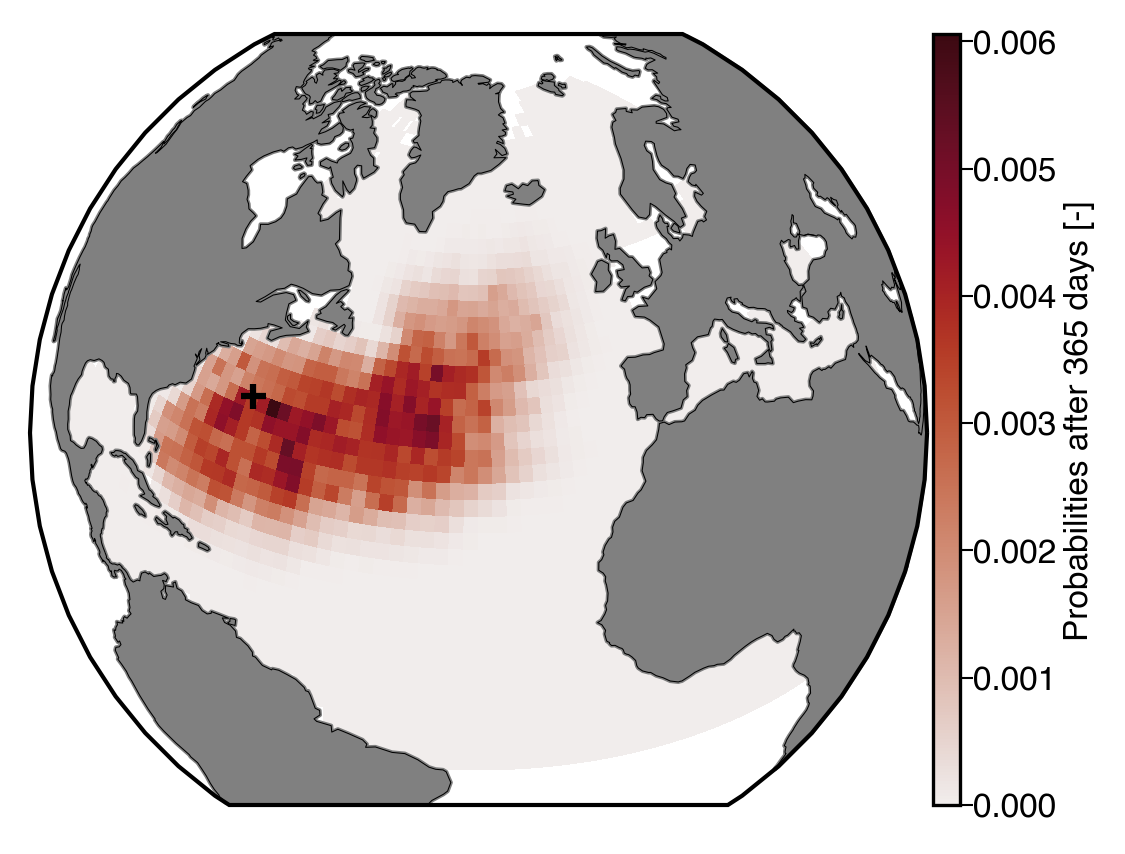

In [12]:
fig = plt.figure(figsize=(4, 4), dpi=300)
mid_lon = (lon[0]+lon[1])/2
mid_lat = (lat[0]+lat[1])/2

ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.NearsidePerspective(central_longitude=mid_lon, central_latitude=mid_lat), aspect='equal')
p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(evolved_density), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
ax1.scatter(-65, 37, color='k', marker='+', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p1, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities after %d days [-]' % (duration), size=8, labelpad=2)